### TypeWriter
This notebook runs the TypeWriter method for predicting types of Python methods. 

In [2]:
from gh_query import load_json, gen_json_file, find_current_repos
from typewriter import config_TW
from os.path import join, exists, isdir
import os
import re
import pickle
import pandas as pd
import numpy as np
import result_proc
import ast
import random
from importlib import reload

In [3]:
import platform
platform.python_version()

'3.6.9'

### Cleaning

In [ ]:
from result_proc import copy_results, clean_output
# Copying the results and cleaning the output of last run
#copy_results('./output/reports/', './results/')

# Delete all the files in the output folder
#clean_output('./output/')

### Select Python projects

The path to the data files including Python repositories

In [4]:
DATA_DIR = '/home/amir/projects/ML4SE/data'

Here, we only select Python projects that has `mypy` as one of its dependencies

In [5]:
repos = load_json(join(DATA_DIR, 'mypy-dependents-by-stars.json'))
 
gen_json_file('./data/py_projects_all.json', repos,
              find_current_repos(join(DATA_DIR, 'full_dataset/'), True))

Loads selected repos

In [6]:
repos = load_json('./data/py_projects_all.json')
print("number of projects:", len(repos))

number of projects: 4910


### Create output folder and dirs

Give a name to output directory. It'll be created automatically.

In [4]:
OUTPUT_DIR = '/home/amir/projects/dl-type-python/output_jun9'

In [5]:
OUTPUT_EMBEDDINGS_DIRECTORY = join(OUTPUT_DIR, 'embed')
OUTPUT_DIRECTORY_TW = join('/home/amir/projects/dl-type-python/output_new_pipeline', 'funcs')
AVAILABLE_TYPES_DIR = join('/home/amir/projects/dl-type-python/output_new_pipeline', 'avl_types')
RESULTS_DIR = join(OUTPUT_DIR, "results")

ML_INPUTS_PATH_TW = join(OUTPUT_DIR, "ml_inputs")
ML_PARAM_TW_TRAIN = join(ML_INPUTS_PATH_TW, "_ml_param_train.csv")
ML_PARAM_TW_TEST = join(ML_INPUTS_PATH_TW, "_ml_param_test.csv")
ML_RET_TW_TRAIN = join(ML_INPUTS_PATH_TW, "_ml_ret_train.csv")
ML_RET_TW_TEST = join(ML_INPUTS_PATH_TW, "_ml_ret_test.csv")

VECTOR_OUTPUT_DIR_TW = join(OUTPUT_DIR, 'vectors')
VECTOR_OUTPUT_TRAIN = join(VECTOR_OUTPUT_DIR_TW, "train")
VECTOR_OUTPUT_TEST = join(VECTOR_OUTPUT_DIR_TW, "test")

W2V_MODEL_TOKEN_DIR = join(OUTPUT_EMBEDDINGS_DIRECTORY, 'w2v_token_model.bin')
W2V_MODEL_COMMENTS_DIR = join(OUTPUT_EMBEDDINGS_DIRECTORY, 'w2v_comments_model.bin')

DATA_FILE_TW = join(ML_INPUTS_PATH_TW, "_all_data.csv")

LABEL_ENCODER_PATH_TW = join(ML_INPUTS_PATH_TW, "label_encoder.pkl")
TYPES_FILE_TW = join(ML_INPUTS_PATH_TW, "_most_frequent_types.csv")

TB_WRITER_PATH = "/home/amir/projects/runs"

dirs = [OUTPUT_EMBEDDINGS_DIRECTORY, OUTPUT_DIRECTORY_TW, AVAILABLE_TYPES_DIR, RESULTS_DIR,
        ML_INPUTS_PATH_TW, VECTOR_OUTPUT_DIR_TW, VECTOR_OUTPUT_TRAIN, VECTOR_OUTPUT_TEST]

In [3]:
OUTPUT_EMBEDDINGS_DIRECTORY = join(OUTPUT_DIR, 'embed')
OUTPUT_DIRECTORY_TW = join(OUTPUT_DIR, 'funcs')
AVAILABLE_TYPES_DIR = join(OUTPUT_DIR, 'avl_types')
RESULTS_DIR = join(OUTPUT_DIR, "results")

ML_INPUTS_PATH_TW = join(OUTPUT_DIR, "ml_inputs")
ML_PARAM_TW_TRAIN = join(ML_INPUTS_PATH_TW, "_ml_param_train.csv")
ML_PARAM_TW_TEST = join(ML_INPUTS_PATH_TW, "_ml_param_test.csv")
ML_RET_TW_TRAIN = join(ML_INPUTS_PATH_TW, "_ml_ret_train.csv")
ML_RET_TW_TEST = join(ML_INPUTS_PATH_TW, "_ml_ret_test.csv")

VECTOR_OUTPUT_DIR_TW = join(OUTPUT_DIR, 'vectors')
VECTOR_OUTPUT_TRAIN = join(VECTOR_OUTPUT_DIR_TW, "train")
VECTOR_OUTPUT_TEST = join(VECTOR_OUTPUT_DIR_TW, "test")

W2V_MODEL_TOKEN_DIR = join(OUTPUT_EMBEDDINGS_DIRECTORY, 'w2v_token_model.bin')
W2V_MODEL_COMMENTS_DIR = join(OUTPUT_EMBEDDINGS_DIRECTORY, 'w2v_comments_model.bin')

DATA_FILE_TW = join(ML_INPUTS_PATH_TW, "_all_data.csv")

LABEL_ENCODER_PATH_TW = join(ML_INPUTS_PATH_TW, "label_encoder.pkl")
TYPES_FILE_TW = join(ML_INPUTS_PATH_TW, "_most_frequent_types.csv")

TB_WRITER_PATH = "/home/amir/projects/runs"

dirs = [OUTPUT_EMBEDDINGS_DIRECTORY, OUTPUT_DIRECTORY_TW, AVAILABLE_TYPES_DIR, RESULTS_DIR,
        ML_INPUTS_PATH_TW, VECTOR_OUTPUT_DIR_TW, VECTOR_OUTPUT_TRAIN, VECTOR_OUTPUT_TEST]

In [8]:
if not isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

config_TW.create_dirs(dirs)

### Step 1: Extracting functions
Extract natural language information and preprocess functions

In [11]:
from dltpy.preprocessing.pipeline import Pipeline
p = Pipeline(join(DATA_DIR, 'full_dataset/'), OUTPUT_DIRECTORY_TW,
             AVAILABLE_TYPES_DIR)
p.run_pipeline_manual(repos, 24)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/amir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 4910/4910 [55:48<00:00,  1.47it/s]  


Generates dataframe or loads an existing one

In [9]:
from dltpy.input_preparation.generate_df import list_files, parse_df

In [12]:
if config_TW.CACHE_TW and os.path.exists(DATA_FILE_TW):
    print("Loading cached copy")
    df = pd.read_csv(DATA_FILE_TW)
else:
    DATA_FILES = list_files(OUTPUT_DIRECTORY_TW)
    print("Found %d datafiles" % len(DATA_FILES))
    #print(DATA_FILES)
    df = parse_df(DATA_FILES, batch_size=4098)
    print("Dataframe loaded writing it to CSV")
    df.to_csv(DATA_FILE_TW, index=False)

Found 4719 datafiles
Loaded 0/4719 files
Loaded 100/4719 files
Loaded 200/4719 files
Loaded 300/4719 files
Loaded 400/4719 files


/home/amir/py_venv/py_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Loaded 500/4719 files
Loaded 600/4719 files
Loaded 700/4719 files
Loaded 800/4719 files
Loaded 900/4719 files
Loaded 1000/4719 files
Loaded 1100/4719 files
Loaded 1200/4719 files


/home/amir/py_venv/py_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Loaded 1300/4719 files
Loaded 1400/4719 files
Loaded 1500/4719 files
Loaded 1600/4719 files
Loaded 1700/4719 files
Loaded 1800/4719 files
Loaded 1900/4719 files
Loaded 2000/4719 files
Loaded 2100/4719 files
Loaded 2200/4719 files
Loaded 2300/4719 files
Loaded 2400/4719 files
Loaded 2500/4719 files
Loaded 2600/4719 files
Loaded 2700/4719 files
Loaded 2800/4719 files
Loaded 2900/4719 files
Loaded 3000/4719 files
Loaded 3100/4719 files
Loaded 3200/4719 files
Loaded 3300/4719 files
Loaded 3400/4719 files
Loaded 3500/4719 files
Loaded 3600/4719 files
Loaded 3700/4719 files
Loaded 3800/4719 files
Loaded 3900/4719 files
Loaded 4000/4719 files
Loaded 4100/4719 files
Loaded 4200/4719 files
Loaded 4300/4719 files
Loaded 4400/4719 files
Loaded 4500/4719 files
Loaded 4600/4719 files
Loaded 4700/4719 files
Dataframe loaded writing it to CSV


Initial dataset before processing parameter and returns data

In [13]:
df.head(5)

,author,repo,file,has_type,name,docstring,func_descr,arg_names,arg_types,arg_descrs,return_type,return_expr,return_descr,args_occur,arg_names_len,arg_types_len
0,okchaty,common,/home/amir/projects/ML4SE/data/full_dataset/ok...,False,test host file,NaN,NaN,['host'],[''],[''],NaN,[],NaN,['exe host file'],1,1
1,okchaty,common,/home/amir/projects/ML4SE/data/full_dataset/ok...,False,test build dependency,NaN,NaN,"['host', 'pkg']","['', '']","['', '']",NaN,[],NaN,"['pkg host package', 'pkg host assert pkg inst...",2,2
2,etcher-be,epab_test,/home/amir/projects/ML4SE/data/full_dataset/et...,False,read single file,NaN,NaN,['file path'],[''],[''],NaN,['n n join title f read'],NaN,[],1,1
3,etcher-be,epab_test,/home/amir/projects/ML4SE/data/full_dataset/et...,True,read local file,read one text file return join together title ...,read one text file return join together,['file path'],['str'],[''],str,['n n n join map read single file file path'],NaN,[],1,1
4,etcher-be,epab_test,/home/amir/projects/ML4SE/data/full_dataset/et...,False,test dummy,NaN,NaN,[],[],[],NaN,[],NaN,[],0,0


stats of the repositories

In [14]:
def print_dataset_stats(df):
    print("Number of source files: ", len(df.file.unique()))
    print("Number of functions: ", len(df.name))
    print("Number of functions with comments: ",
      df[(~df['return_descr'].isnull()) | (~df['func_descr'].isnull())].shape[0])
    print("Number of functions with return types: ", df['return_type'].count())
    print("Number of functions with both: ",
      df[((~df['return_descr'].isnull()) | (~df['func_descr'].isnull())) & (~df['return_type'].isnull())].shape[0])

In [15]:
print_dataset_stats(df)

Number of source files:  442889
Number of functions:  5718106
Number of functions with comments:  2500142
Number of functions with return types:  490581
Number of functions with both:  204193


Duplicate files in the dataset

In [16]:
from dpu_utils.utils.dataloading import load_jsonl_gz

In [17]:
def repair_data_path(path):
    rep_path = {"/full_data/": '/full_dataset/', "/Users/": '/home/'}
    regex = re.compile("(%s)" % "|".join(map(re.escape, rep_path.keys())))
    return regex.sub(lambda mo: rep_path[mo.string[mo.start():mo.end()]], path)

Select a file from each cluster of duplicate files

In [18]:
clusters_rand_files = [repair_data_path(l.pop(random.randrange(len(l)))) for l in load_jsonl_gz('/home/amir/projects/ML4SE/data/full_data_dups_knn.jsonl.gz')]

In [19]:
all_dup_files = [repair_data_path(f) for l in load_jsonl_gz('/home/amir/projects/ML4SE/data/full_data_dups_knn.jsonl.gz') for f in l]

In [20]:
all_dup_files = set(all_dup_files).difference(set(clusters_rand_files))

In [21]:
len(all_dup_files)

334349

Exclude duplicate files from the whole dataset

In [22]:
df = df[~df['file'].isin(all_dup_files)].copy()

In [23]:
print_dataset_stats(df)

Number of source files:  174828
Number of functions:  2016882
Number of functions with comments:  647286
Number of functions with return types:  261870
Number of functions with both:  94096


Splits the intial dataset based on source files. Later on, we use this to split the datasets.

In [24]:
from sklearn.model_selection import train_test_split
train_files, test_files = train_test_split(pd.DataFrame(df['file'].unique(), columns=['file']),
                                           test_size=0.2)

In [25]:
df_train = df[df['file'].isin(train_files.to_numpy().flatten())]
print("Number of functions in train set: ", df_train.shape[0])

Number of functions in train set:  1613404


In [26]:
df_test = df[df['file'].isin(test_files.to_numpy().flatten())]
print("Number of functions in test set: ", df_test.shape[0])

Number of functions in test set:  403478


### Step 2: Processing functions

In [27]:
from typewriter import prepocessing
reload(prepocessing)
from typewriter.prepocessing import filter_functions, gen_argument_df_TW, gen_most_frequent_avl_types, \
                                    encode_aval_types_TW, make_types_consistent
from dltpy.input_preparation.generate_df import filter_return_dp, format_df, encode_types

In [ ]:
from dltpy.input_preparation import generate_df
reload(generate_df)

Makes type annotations consistent by removing `typing.` from a type.

In [28]:
df = make_types_consistent(df)

In [29]:
print(any([bool(re.match(r'.*typing\..+', str(t))) for t in df['return_type']]))
print(any([bool(re.match(r'.*typing\..+', t)) for t in df['arg_types']]))

False
False


Filters trivial functions such as `__str__` and `__len__` 

In [30]:
df = filter_functions(df)

Functions before dropping on __*__ methods 2016882
Functions after dropping on __*__ methods 1982718
Filtered out 34164 functions.


Extracts informations for functions' arguments

In [31]:
df_params = gen_argument_df_TW(df)

0.0
0.004539223429655654
0.005043581588506283
0.005547939747356911
0.009078446859311308
0.016643819242070732
0.017148177400921363
0.018156893718622617
0.018661251877473247
0.025722266101382042
0.02622662426023267
0.0267309824190833
0.02925277321333644
0.03227892216644021
0.033791996642992095
0.034296354801842725
0.03480071296069335
0.03883557823149838
0.03933993639034901
0.04942709956736157
0.050940174043913454
0.051444532202764084
0.051948890361614715
0.05245324852046534
0.05295760667931597
0.0534619648381666
0.05396632299701722
0.05447068115586785
0.05648811379127037
0.05900990458552351
0.07061014223908796
0.07111450039793858
0.07212321671563984
0.08120166357495115
0.0837234543692043
0.08422781252805492
0.08473217068690556
0.08674960332230806
0.08876703595771057
0.08927139411656121
0.08977575227541183
0.09028011043426246
0.09128882675196372
0.09381061754621686
0.09481933386391812
0.09532369202276875
0.09582805018161937
0.09885419913472314
0.09935855729357378
0.10490649704093068
0.111

0.6198561772274221
0.6203605353862728
0.6208648935451234
0.6259084751336297
0.6304476985632853
0.6435610106934017
0.6440653688522523
0.6445697270111029
0.6450740851699536
0.6455784433288042
0.6460828014876548
0.6465871596465055
0.6470915178053561
0.6475958759642068
0.6481002341230573
0.6486045922819079
0.6586917554589206
0.660709188094323
0.6637353370474268
0.6652484115239787
0.6667614860005305
0.6692832767947837
0.6713007094301863
0.6718050675890369
0.6723094257478875
0.6728137839067381
0.6738225002244393
0.67432685838329
0.6748312165421406
0.6753355747009913
0.6758399328598419
0.6763442910186925
0.6768486491775432
0.6778573654952444
0.6783617236540951
0.6788660818129456
0.6793704399717962
0.6803791562894975
0.6864314541957051
0.6909706776253608
0.7020665571200746
0.704083989755477
0.7076144968674315
0.7111450039793858
0.7116493621382365
0.7131624366147884
0.7146755110913403
0.715179869250191
0.7166929437267427
0.7197190926798466
0.7202234508386972
0.7212321671563985
0.725267032427203

1.46919531673188
1.4696996748907307
1.4702040330495814
1.470708391208432
1.4712127493672826
1.4717171075261333
1.472221465684984
1.4727258238438345
1.4732301820026852
1.4737345401615358
1.4742388983203865
1.474743256479237
1.4752476146380877
1.4757519727969384
1.476256330955789
1.4767606891146396
1.4772650472734903
1.4782737635911916
1.4787781217500422
1.4792824799088928
1.4797868380677435
1.480291196226594
1.4812999125442952
1.4818042707031458
1.4823086288619964
1.482812987020847
1.4838217033385483
1.484326061497399
1.4848304196562496
1.485839135973951
1.4863434941328015
1.4868478522916522
1.4873522104505028
1.4878565686093534
1.488360926768204
1.4888652849270547
1.4893696430859054
1.4918914338801585
1.4923957920390092
1.4929001501978596
1.4939088665155609
1.4949175828332621
1.4954219409921128
1.496430657309814
1.4974393736275153
1.4984480899452166
1.5055091041691253
1.5095439694399304
1.510048327598781
1.5105526857576317
1.5110570439164823
1.511561402075333
1.5120657602341836
1.51257

1.9912060111422805
2.0017975324781436
2.003814965113546
2.0043193232723966
2.005328039590098
2.0058323977489487
2.006336755907799
2.00684111406665
2.0073454722255004
2.0078498303843513
2.0083541885432017
2.0088585467020525
2.009362904860903
2.009867263019754
2.0103716211786042
2.010875979337455
2.012389053814007
2.0128934119728576
2.013397770131708
2.013902128290559
2.020458784355617
2.024493649626422
2.03105030569148
2.0320590220091814
2.033572096485733
2.034076454644584
2.0350851709622853
2.038111319915389
2.0386156780742395
2.0411374688684925
2.0426505433450446
2.0441636178215963
2.0451723341392976
2.0481984830924014
2.0497115575689535
2.0517289902043556
2.052737706522057
2.053746422839758
2.054250780998609
2.059798720745966
2.0623205115402192
2.0628248696990696
2.0633292278579205
2.064842302334472
2.0658510186521735
2.0688771676052773
2.07089460024068
2.073416391034933
2.076946898146887
2.077451256305738
2.079973047099991
2.080981763417692
2.081486121576543
2.0829991960530947
2.083

2.4794247089096886
2.4799290670685394
2.48043342522739
2.4809377833862407
2.481442141545091
2.4819464997039415
2.4824508578627924
2.482955216021643
2.4834595741804937
2.483963932339344
2.484468290498195
2.4849726486570454
2.4854770068158962
2.4935467373575064
2.4960685281517594
2.49657288631061
2.4970772444694607
2.497581602628311
2.498085960787162
2.4985903189460124
2.499094677104863
2.4995990352637136
2.5036339005345187
2.507164407646473
2.508677482123025
2.51271234739383
2.5132167055526806
2.514225421870382
2.515234138188083
2.515738496346934
2.521286436094291
2.5258256595239463
2.5298605247947514
2.5303648829536023
2.535408464542108
2.535912822700959
2.538938971654063
2.543982553242569
2.5444869114014197
2.5465043440368222
2.548017418513374
2.5555827908961333
2.562139446961192
2.567183028549698
2.568191744867399
2.572226610138204
2.572730968297055
2.5802963406798143
2.5808006988386647
2.5813050569975156
2.5843312059506194
2.586348638586022
2.5868529967448723
2.588870429380275
2.589

Ignore `self` arguments and args with type of `Any` or `None`.

In [32]:
args_count = df_params['arg_name'].count()
args_with_annot = df_params[df_params['arg_type'] != ''].shape[0]
print("Number of arguments: ", args_count)
print("Args with type annotations: ", args_with_annot)
df_params = df_params[(df_params['arg_name'] != 'self') & ((df_params['arg_type'] != 'Any') & \
                                                          (df_params['arg_type'] != 'None'))]
print("Ignored trivial types: ", (args_count - df_params.shape[0]))

Number of arguments:  3624940
Args with type annotations:  362614
Ignored trivial types:  1278431


Ignore arguments without a type

In [33]:
df_params = df_params[df_params['arg_type'] != '']
print("Number of arguments with types: ", df_params.shape[0])

Number of arguments with types:  351571


Filters out functions:
- without a return type
- with the return type of `Any` or `None`
- without a return expression

In [34]:
df = filter_return_dp(df)

Functions before dropping on return type 1982718
Functions after dropping on return type 1982718
Functions before dropping nan, None, Any return type 1982718
Functions after dropping nan return type 158141
Functions before dropping on empty return expression 158141
Functions after dropping on empty return expression 144445


In [35]:
df = format_df(df)

In [36]:
df.head(10)

,author,repo,file,has_type,name,docstring,func_descr,arg_names,arg_types,arg_descrs,return_type,return_expr,return_descr,args_occur,arg_names_len,arg_types_len
46,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,origin,helper get original paper algorithm return ori...,helper get original paper algorithm,[self],[],[],str,[http www c toronto edu vmnih doc dqn pdf],original paper algorithm,[],1,1
47,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,description,helper get brief description algorithm return ...,helper get brief description algorithm,[self],[],[],str,[description],brief description algorithm,[],1,1
64,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,origin,helper get original paper algorithm return ori...,helper get original paper algorithm,[self],[],[],str,[http paper nip cc paper policy gradient metho...,original paper algorithm,[],1,1
65,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,description,helper get brief description algorithm return ...,helper get brief description algorithm,[self],[],[],str,[description],brief description algorithm,[],1,1
80,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,origin,helper get original paper algorithm return ori...,helper get original paper algorithm,[self],[],[],str,[http arxiv org pdf pdf],original paper algorithm,[],1,1
81,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,description,helper get brief description algorithm return ...,helper get brief description algorithm,[self],[],[],str,[description],brief description algorithm,[],1,1
115,MarcioPorto,rlib,/home/amir/projects/ML4SE/data/full_dataset/Ma...,True,train,train agent interaction environment args num e...,train agent interaction environment,"[self, num episode, max t, add noise, score wi...","[, int, int, bool, int, int]","[, number episode train agent, maximum number ...",List[float],[self episode score],score episode,['self start env self episode score current av...,6,6
157,ppb,ppb-vector,/home/amir/projects/ML4SE/data/full_dataset/pp...,True,unpack,NaN,NaN,[value],[VectorLike],[],"Tuple[float, float]","[value x value y, float value float value, flo...",NaN,[],1,1
158,ppb,ppb-vector,/home/amir/projects/ML4SE/data/full_dataset/pp...,True,bool,check whether vector non zero assert vector as...,check whether vector non zero,[self],[],[],bool,[self],NaN,[],1,1
159,ppb,ppb-vector,/home/amir/projects/ML4SE/data/full_dataset/pp...,True,length,compute length vector vector length,compute length vector,[self],[],[],float,[hypot self x self y],NaN,[],1,1


Encode types as int

In [37]:
df, df_params, label_encoder, uniq_types = encode_types(df, df_params, TYPES_FILE_TW)

Found 41919 unique types in a total of 496016 types.
Remapping uncommon types for functions
Remapping uncommon types for arguments
Fitting label encoder on transformed types
Store type mapping with counts
Transforming return types
Transforming args types


Add argument names as a string except self

In [38]:
df['arg_names_str'] = df['arg_names'].apply(lambda l: " ".join([v for v in l if v != 'self']))

Add return expressions as a string, replace self. and self within expressions

In [39]:
df['return_expr_str'] = df['return_expr'].apply(lambda l: " ".join([re.sub(r"self\.?", '', v) for v in l]))

Drop all columns useless for the ML algorithms

In [40]:
df = df.drop(columns=['author', 'repo', 'has_type', 'arg_names', 'arg_types', 'arg_descrs', 'return_expr'])

Extracts top 1000 available types (**Previous Approach**)

In [29]:
if config_TW.CACHE_TW and os.path.exists(os.path.join(AVAILABLE_TYPES_DIR,
                                         'top_%d_types.csv' % (config_TW.AVAILABLE_TYPES_NUMBER-1))):
    df_types = pd.read_csv(os.path.join(AVAILABLE_TYPES_DIR,
                                         'top_%d_types.csv' % (config_TW.AVAILABLE_TYPES_NUMBER-1)))
else:
    df_types = gen_most_frequent_avl_types(AVAILABLE_TYPES_DIR, AVAILABLE_TYPES_DIR,
                                           config_TW.AVAILABLE_TYPES_NUMBER-1, True)

In [30]:
df_params, df = encode_aval_types_TW(df_params, df, df_types)

In [31]:
df['ret_aval_enc'].head(10)

5     999
8     137
10    999
12    999
13    999
14    999
15    999
16    999
17    999
18    999
Name: ret_aval_enc, dtype: int64

Finding top 1000 available types from a pre-computed dataset of available import types (**New**)

In [41]:
df_types = pd.read_csv('/datasets/repos-members-4.9k.csv')

In [42]:
from ast import literal_eval
all_aval_types = [t for l in df_types['types'].tolist() for t in literal_eval(l)]

Frequency of all the extracted visible types

In [43]:
from collections import Counter
avl_types_counter = Counter(all_aval_types)

In [44]:
df_types = pd.DataFrame.from_records(avl_types_counter.most_common(config_TW.AVAILABLE_TYPES_NUMBER-1), 
                                     columns=['Types', 'Count'])
df_types.to_csv(join(AVAILABLE_TYPES_DIR, "top_%d_types_new.csv" % config_TW.AVAILABLE_TYPES_NUMBER),
                index=False)

In [45]:
df_types.head(10)

,Types,Count
0,collections.abc.Mapping,400428
1,abc.ABCMeta,399915
2,functools.partial,395727
3,selectors._BaseSelectorImpl,395390
4,selectors.DefaultSelector,395390
5,selectors.BaseSelector,395390
6,selectors.SelectSelector,395390
7,selectors.PollSelector,395390
8,selectors._SelectorMapping,395390
9,selectors.SelectorKey,395390


Encode new visible types

In [46]:
types = df_types['Types'].tolist()
def trans_aval_type(x):
        for i, t in enumerate(types):
            if x in t:
                return i
        return len(types)

df_params['param_aval_new_enc'] = df_params['arg_type'].apply(trans_aval_type)
df['ret_aval_new_enc'] = df['return_type'].apply(trans_aval_type)

Calculates the datapoints and types coverage

In [36]:
all_enc_types = np.concatenate((df_params['arg_type_enc'].values, df['return_type_enc'].values))
other_type_count = np.count_nonzero(all_enc_types == label_encoder.transform(['other'])[0])
print("Number of datapoints with other types: ", other_type_count)
print("The percentage of covered unique types: %.2f%%" % \
      ((config_TW.AVAILABLE_TYPES_NUMBER / len(uniq_types))*100))
print("The percentage of all datapoints covered by considered types: %.2f%%" %\
      ((1 - other_type_count / all_enc_types.shape[0])*100))

Number of datapoints with other types:  113575
The percentage of covered unique types: 2.59%
The percentage of all datapoints covered by considered types: 73.71%


Final arguments data before embedding step

In [47]:
df_params.head(10)

,file,func_name,func_descr,arg_name,arg_type,arg_comment,other_args,arg_occur,arg_type_t,arg_type_enc,param_aval_new_enc
110,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initializes parameter build model,state size,int,dimension state,state size action size hide layer input size h...,[q network seed softmax output softmax outpu...,int,897,149
111,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initializes parameter build model,action size,int,dimension action,state size action size hide layer input size h...,[q network seed softmax output softmax outpu...,int,897,149
112,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initializes parameter build model,hide layer input size,int,dimension hidden layer input,state size action size hide layer input size h...,[q network seed softmax output softmax outpu...,int,897,149
113,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initializes parameter build model,hide layer output size,int,dimension hidden layer output,state size action size hide layer input size h...,[q network seed softmax output softmax outpu...,int,897,149
114,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initializes parameter build model,seed,int,random seed,state size action size hide layer input size h...,[q network seed softmax output softmax outpu...,int,897,149
115,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initializes parameter build model,softmax output,bool,decides use softmax activation output layer,state size action size hide layer input size h...,[q network seed softmax output softmax outpu...,bool,866,388
119,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initialize dqn agent object,state size,int,dimension state,state size action size qnetwork local qnetwork...,[dqn agent state size state size action size...,int,897,149
120,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initialize dqn agent object,action size,int,dimension action,state size action size qnetwork local qnetwork...,[dqn agent state size state size action size...,int,897,149
125,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initialize dqn agent object,seed,int,random seed,state size action size qnetwork local qnetwork...,[dqn agent state size state size action size...,int,897,149
126,/home/amir/projects/ML4SE/data/full_dataset/Ma...,init,initialize dqn agent object,device,str,identifier device use py torch,state size action size qnetwork local qnetwork...,[dqn agent state size state size action size...,str,956,12


Final return data before embedding step

In [48]:
df.head(10)

,file,name,docstring,func_descr,return_type,return_descr,args_occur,arg_names_len,arg_types_len,return_type_t,return_type_enc,arg_names_str,return_expr_str,ret_aval_new_enc
46,/home/amir/projects/ML4SE/data/full_dataset/Ma...,origin,helper get original paper algorithm return ori...,helper get original paper algorithm,str,original paper algorithm,[],1,1,str,956,,http www c toronto edu vmnih doc dqn pdf,12
47,/home/amir/projects/ML4SE/data/full_dataset/Ma...,description,helper get brief description algorithm return ...,helper get brief description algorithm,str,brief description algorithm,[],1,1,str,956,,description,12
64,/home/amir/projects/ML4SE/data/full_dataset/Ma...,origin,helper get original paper algorithm return ori...,helper get original paper algorithm,str,original paper algorithm,[],1,1,str,956,,http paper nip cc paper policy gradient method...,12
65,/home/amir/projects/ML4SE/data/full_dataset/Ma...,description,helper get brief description algorithm return ...,helper get brief description algorithm,str,brief description algorithm,[],1,1,str,956,,description,12
80,/home/amir/projects/ML4SE/data/full_dataset/Ma...,origin,helper get original paper algorithm return ori...,helper get original paper algorithm,str,original paper algorithm,[],1,1,str,956,,http arxiv org pdf pdf,12
81,/home/amir/projects/ML4SE/data/full_dataset/Ma...,description,helper get brief description algorithm return ...,helper get brief description algorithm,str,brief description algorithm,[],1,1,str,956,,description,12
115,/home/amir/projects/ML4SE/data/full_dataset/Ma...,train,train agent interaction environment args num e...,train agent interaction environment,List[float],score episode,['self start env self episode score current av...,6,6,List[float],392,num episode max t add noise score window size ...,episode score,999
157,/home/amir/projects/ML4SE/data/full_dataset/pp...,unpack,NaN,NaN,"Tuple[float, float]",NaN,[],1,1,"Tuple[float, float]",743,value,value x value y float value float value float ...,999
158,/home/amir/projects/ML4SE/data/full_dataset/pp...,bool,check whether vector non zero assert vector as...,check whether vector non zero,bool,NaN,[],1,1,bool,866,,,388
159,/home/amir/projects/ML4SE/data/full_dataset/pp...,length,compute length vector vector length,compute length vector,float,NaN,[],1,1,float,895,,hypot x y,385


Splits parameters and returns type dataset by file into a train and test sets

In [49]:
df_params_train = df_params[df_params['file'].isin(train_files.to_numpy().flatten())]
df_params_test = df_params[df_params['file'].isin(test_files.to_numpy().flatten())]
print(df_params_train.shape, df_params_test.shape)

(283814, 11) (67757, 11)


In [50]:
df_ret_train = df[df['file'].isin(train_files.to_numpy().flatten())]
df_ret_test = df[df['file'].isin(test_files.to_numpy().flatten())]
print(df_ret_train.shape, df_ret_test.shape)

(116483, 14) (27962, 14)


Make sure that there is no overlap between the train and test sets.

In [51]:
list(set(df_params_train['file'].tolist()).intersection(set(df_params_test['file'].tolist())))

[]

In [52]:
list(set(df_ret_train['file'].tolist()).intersection(set(df_ret_test['file'].tolist())))

[]

Store the dataframes and the label encoder

In [53]:
if not os.path.exists(ML_INPUTS_PATH_TW):
    os.makedirs(ML_INPUTS_PATH_TW)

with open(LABEL_ENCODER_PATH_TW, 'wb') as file:
    pickle.dump(label_encoder, file)
    
#df.to_csv(config.ML_RETURN_DF_PATH_TW, index=False)
#df_params.to_csv(config.ML_PARAM_DF_PATH_TW, index=False)
df_params_train.to_csv(ML_PARAM_TW_TRAIN, index=False)
df_params_test.to_csv(ML_PARAM_TW_TEST, index=False)
df_ret_train.to_csv(ML_RET_TW_TRAIN, index=False)
df_ret_test.to_csv(ML_RET_TW_TEST, index=False)

Plots 20 most frequent types in the dataset

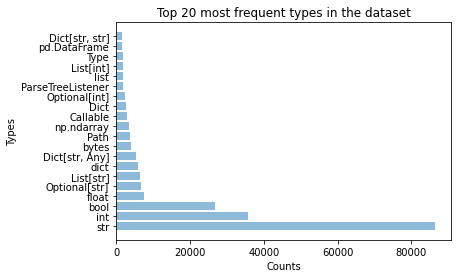

In [44]:
result_proc.plot_top_n_types(TYPES_FILE_TW, 20)

### Step 3: Embeddings

In [54]:
from typewriter import extraction
from typewriter.extraction import EmbeddingTypeWriter
from gensim.models import Word2Vec

Loads dataset for parametes and return types

In [55]:
param_df = pd.read_csv(ML_PARAM_TW_TRAIN)
return_df = pd.read_csv(ML_RET_TW_TRAIN)

print("Number of parameters types:", param_df.shape[0])
print("Number of returns types", return_df.shape[0])

Number of parameters types: 283814
Number of returns types 116483


Train embeddings

In [56]:
embedder = EmbeddingTypeWriter(param_df, return_df, W2V_MODEL_COMMENTS_DIR,
                               W2V_MODEL_TOKEN_DIR)
embedder.train_token_model()
embedder.train_comment_model()

Time to build vocab: 0.14 mins
Time to train model: 3.69 mins
Time to build vocab: 0.02 mins
Time to train model: 0.39 mins


Loads pre-trained W2V models for TypeWriter

In [57]:
w2v_token_model = Word2Vec.load(W2V_MODEL_TOKEN_DIR)
w2v_comments_model = Word2Vec.load(W2V_MODEL_COMMENTS_DIR)

stats of the W2V models:

In [58]:
print("W2V statistics: ")
print("W2V token model total amount of words : " + str(w2v_token_model.corpus_total_words))
print("W2V comments model total amount of words : " + str(w2v_comments_model.corpus_total_words))
print("\n Top 20 words for token model:")
print(w2v_token_model.wv.index2entity[:20])
print("\n Top 20 words for comments model:")
print(w2v_comments_model.wv.index2entity[:20])

W2V statistics: 
W2V token model total amount of words : 6548675
W2V comments model total amount of words : 501942

 Top 20 words for token model:
['name', 'id', '[]', 'get', 'type', 'init', 'path', 'data', 'file', 'key', 'token', 'user', 'none', 'value', 'size', 'state', 'max', 'config', 'node', 'address']

 Top 20 words for comments model:
['return', 'list', 'name', 'give', 'file', 'get', 'use', 'value', 'data', 'string', 'object', 'path', 'id', 'type', 'class', 'number', 'true', 'function', 'set', 'create']


### Step 4: Vector Representation

In [59]:
from typewriter.extraction import IdentifierSequence, TokenSequence, CommentSequence, \
                                  process_datapoints_TW, gen_aval_types_datapoints

Process parameter datapoints

In [60]:
id_trans_func_param = lambda row: IdentifierSequence(w2v_token_model, row.arg_name, row.other_args,
                                                     row.func_name)
token_trans_func_param = lambda row: TokenSequence(w2v_token_model, 7, 3, row.arg_occur, None)

cm_trans_func_param = lambda row: CommentSequence(w2v_comments_model, row.func_descr, row.arg_comment, None)

Identifiers

In [61]:
dp_ids_param_X_train = process_datapoints_TW(ML_PARAM_TW_TRAIN, VECTOR_OUTPUT_TRAIN,
                                             'identifiers_', 'param_train', id_trans_func_param)

In [62]:
dp_ids_param_X_test = process_datapoints_TW(ML_PARAM_TW_TEST, VECTOR_OUTPUT_TEST,
                                            'identifiers_', 'param_test', id_trans_func_param)

Tokens

In [63]:
dp_tokens_param_X_train = process_datapoints_TW(ML_PARAM_TW_TRAIN, VECTOR_OUTPUT_TRAIN,
                                                'tokens_', 'param_train', token_trans_func_param)

In [64]:
dp_tokens_param_X_test = process_datapoints_TW(ML_PARAM_TW_TEST, VECTOR_OUTPUT_TEST,
                                                'tokens_', 'param_test', token_trans_func_param)

Comments

In [65]:
dp_cms_param_X_train = process_datapoints_TW(ML_PARAM_TW_TRAIN, VECTOR_OUTPUT_TRAIN,
                                            'comments_', 'param_train', cm_trans_func_param)

In [66]:
dp_cms_param_X_test = process_datapoints_TW(ML_PARAM_TW_TEST, VECTOR_OUTPUT_TEST,
                                            'comments_', 'param_test', cm_trans_func_param)

In [67]:
print("Identifiers' train set parameters: ", dp_ids_param_X_train.shape)
print("Tokens' train set parameters: ", dp_tokens_param_X_train.shape)
print("Comments' train parameters: ", dp_cms_param_X_train.shape)
print("Identifiers' test set parameters: ", dp_ids_param_X_test.shape)
print("Tokens' test set parameters: ", dp_tokens_param_X_test.shape)
print("Comments' test set parameters: ", dp_cms_param_X_test.shape)

Identifiers' train set parameters:  (283814, 31, 100)
Tokens' train set parameters:  (283814, 21, 100)
Comments' train parameters:  (283814, 40, 100)
Identifiers' test set parameters:  (67757, 31, 100)
Tokens' test set parameters:  (67757, 21, 100)
Comments' test set parameters:  (67757, 40, 100)


Process returns datapoints

In [68]:
id_trans_func_ret = lambda row: IdentifierSequence(w2v_token_model, None, row.arg_names_str, row.name)
token_trans_func_ret = lambda row: TokenSequence(w2v_token_model, 7, 3, None, row.return_expr_str)
cm_trans_func_ret = lambda row: CommentSequence(w2v_comments_model, row.func_descr, None, row.return_descr)

Identifiers

In [69]:
dp_ids_ret_X_train = process_datapoints_TW(ML_RET_TW_TRAIN, VECTOR_OUTPUT_TRAIN,
                                                     'identifiers_', 'ret_train', id_trans_func_ret)

In [70]:
dp_ids_ret_X_test = process_datapoints_TW(ML_RET_TW_TEST, VECTOR_OUTPUT_TEST,
                                                    'identifiers_', 'ret_test', id_trans_func_ret)

Tokens

In [71]:
dp_tokens_ret_X_train = process_datapoints_TW(ML_RET_TW_TRAIN, VECTOR_OUTPUT_TRAIN,
                                                        'tokens_', 'ret_train', token_trans_func_ret)

In [72]:
dp_tokens_ret_X_test = process_datapoints_TW(ML_RET_TW_TEST, VECTOR_OUTPUT_TEST,
                                                        'tokens_', 'ret_test', token_trans_func_ret)

Comments

In [73]:
dp_cms_ret_X_train = process_datapoints_TW(ML_RET_TW_TRAIN, VECTOR_OUTPUT_TRAIN, 
                                                     'comments_', 'ret_train', cm_trans_func_ret)

In [74]:
dp_cms_ret_X_test = process_datapoints_TW(ML_RET_TW_TEST, VECTOR_OUTPUT_TEST, 
                                                     'comments_', 'ret_test', cm_trans_func_ret)

In [75]:
print("Identifiers' train set return: ", dp_ids_ret_X_train.shape)
print("Identifiers' test set return: ", dp_ids_ret_X_test.shape)
print("Tokens' train set return: ", dp_tokens_ret_X_train.shape)
print("Tokens' test set return: ", dp_tokens_ret_X_test.shape)
print("Comments' train set return:" , dp_cms_ret_X_train.shape)
print("Comments' test set return:" , dp_cms_ret_X_test.shape)

Identifiers' train set return:  (116483, 31, 100)
Identifiers' test set return:  (27962, 31, 100)
Tokens' train set return:  (116483, 21, 100)
Tokens' test set return:  (27962, 21, 100)
Comments' train set return: (116483, 40, 100)
Comments' test set return: (27962, 40, 100)


Generates datapoints for available types

In [81]:
dp_params_train_aval_types, dp_ret_train_aval_types = gen_aval_types_datapoints(ML_PARAM_TW_TRAIN,
                                                                                ML_RET_TW_TRAIN,
                                                                               'train',
                                                                                VECTOR_OUTPUT_TRAIN)

AttributeError: 'Series' object has no attribute 'param_aval_enc'

In [ ]:
dp_params_test_aval_types, dp_ret_test_aval_types = gen_aval_types_datapoints(ML_PARAM_TW_TEST,
                                                                              ML_RET_TW_TEST,
                                                                              'test',
                                                                              VECTOR_OUTPUT_TEST)

In [ ]:
print("Available types-parameters-train:", dp_params_train_aval_types.shape)
print("Available types-returns-train:", dp_ret_train_aval_types.shape)
print("Available types-parameters-test:", dp_params_test_aval_types.shape)
print("Available types-returns-test:", dp_ret_test_aval_types.shape)

Creating datapoints for new visible types

In [76]:
from typewriter.extraction import type_vector
def gen_new_aval_types_dp(df_params, df_ret, set_type, output_path):
    df_params = pd.read_csv(df_params)
    df_ret = pd.read_csv(df_ret)

    aval_types_params = np.stack(df_params.apply(lambda row: type_vector(config_TW.AVAILABLE_TYPES_NUMBER,
                                                                         row.param_aval_new_enc), axis=1), axis=0)
    aval_types_ret = np.stack(df_ret.apply(lambda row: type_vector(config_TW.AVAILABLE_TYPES_NUMBER,
                                                                   row.ret_aval_new_enc), axis=1), axis=0)

    np.save(join(output_path, f'params_{set_type}_new_aval_types_dp'), aval_types_params)
    np.save(join(output_path, f'ret_{set_type}_new_aval_types_dp'), aval_types_ret)

    return aval_types_params, aval_types_ret

In [77]:
gen_new_aval_types_dp(ML_PARAM_TW_TRAIN, ML_RET_TW_TRAIN, 'train', VECTOR_OUTPUT_TRAIN)
gen_new_aval_types_dp(ML_PARAM_TW_TEST, ML_RET_TW_TEST, 'test', VECTOR_OUTPUT_TEST)

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]))

Generates type vectors.

In [78]:
from dltpy.input_preparation.df_to_vec import generate_labels

In [79]:
params_y_train, ret_y_train = generate_labels(ML_PARAM_TW_TRAIN, ML_RET_TW_TRAIN,
                                              'train', VECTOR_OUTPUT_TRAIN)

In [80]:
params_y_test, ret_y_test = generate_labels(ML_PARAM_TW_TEST, ML_RET_TW_TEST,
                                            'test', VECTOR_OUTPUT_TEST)

### Step 5: Learning the neural model

In [6]:
from typewriter.model import load_data_tensors_TW, TWModel, train_loop_TW, \
                             evaluate_TW, report_TW, load_label_tensors_TW, \
                             TWModelA, EnhancedTWModel, BaseLineModel
from statistics import mean
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"-- Using {device} for training.")

-- Using cpu for training.


A writer for the Tensorboard

In [83]:
tb_writer = SummaryWriter(join(TB_WRITER_PATH, 'tw_enh_4'))

In [7]:
from typewriter import model as model_tw
reload(model_tw)

<module 'typewriter.model' from '/home/amir/projects/dl-type-python/typewriter/model.py'>

Loads parameters' data vectors

In [ ]:
def load_param_train_data():
    return load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'identifiers_param_train_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'tokens_param_train_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'comments_param_train_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_aval_types_dp.npy')), \
           load_label_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_datapoints_y.npy'))

def load_param_test_data():
    return load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'identifiers_param_test_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'tokens_param_test_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'comments_param_test_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_aval_types_dp.npy')), \
           load_label_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_datapoints_y.npy'))

Loads return' data vectors

In [ ]:
def load_ret_train_data():
    return load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'identifiers_ret_train_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'tokens_ret_train_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'comments_ret_train_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_aval_types_dp.npy')), \
           load_label_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_datapoints_y.npy'))

def load_ret_test_data():
    return load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'identifiers_ret_test_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'tokens_ret_test_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'comments_ret_test_datapoints_x.npy')), \
           load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_aval_types_dp.npy')), \
           load_label_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_datapoints_y.npy'))

Concatanates parameters and return data vectors for combined prediction

In [6]:
def load_combined_train_data():
    return torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'identifiers_param_train_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'identifiers_ret_train_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'tokens_param_train_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'tokens_ret_train_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'comments_param_train_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'comments_ret_train_datapoints_x.npy')))), \
           torch.cat((load_label_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_datapoints_y.npy')),
                      load_label_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_datapoints_y.npy'))))

def load_combined_test_data():
    return torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'identifiers_param_test_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'identifiers_ret_test_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'tokens_param_test_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'tokens_ret_test_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'comments_param_test_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'comments_ret_test_datapoints_x.npy')))), \
           torch.cat((load_label_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_datapoints_y.npy')),
                      load_label_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_datapoints_y.npy'))))

def load_aval_types_data():
    return torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_aval_types_dp.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_aval_types_dp.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_aval_types_dp.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_aval_types_dp.npy')))),\
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_new_aval_types_dp.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_new_aval_types_dp.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_new_aval_types_dp.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_new_aval_types_dp.npy'))))

In [7]:
def load_combined_train_data():
    return torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'identifiers_param_train_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'identifiers_ret_train_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'tokens_param_train_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'tokens_ret_train_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'comments_param_train_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'comments_ret_train_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_aval_types_dp.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_aval_types_dp.npy')))), \
           torch.cat((load_label_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'params_train_datapoints_y.npy')),
                      load_label_tensors_TW(join(VECTOR_OUTPUT_TRAIN, 'ret_train_datapoints_y.npy'))))

def load_combined_test_data():
    return torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'identifiers_param_test_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'identifiers_ret_test_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'tokens_param_test_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'tokens_ret_test_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'comments_param_test_datapoints_x.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'comments_ret_test_datapoints_x.npy')))), \
           torch.cat((load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_aval_types_dp.npy')),
                      load_data_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_aval_types_dp.npy')))), \
           torch.cat((load_label_tensors_TW(join(VECTOR_OUTPUT_TEST, 'params_test_datapoints_y.npy')),
                      load_label_tensors_TW(join(VECTOR_OUTPUT_TEST, 'ret_test_datapoints_y.npy'))))

Datasets

In [ ]:
datasets_train = {'combined': load_combined_train_data,
                  'return': load_ret_train_data,
                  'argument': load_param_train_data}
datasets_test = {'combined': load_combined_test_data,
                 'return': load_ret_test_data,
                 'argument': load_param_test_data}

In [7]:
datasets_train = {'combined': load_combined_train_data}
datasets_test = {'combined': load_combined_test_data}

Learning parameters

In [27]:
input_size = config_TW.W2V_VEC_LENGTH
hidden_size = 512
output_size = 1000
num_layers = 1
learning_rate = 0.002
dropout_rate = 0.25
epochs = 25
top_n_pred = [1, 3, 5]
n_rep = 1
batch_size = 4098
#train_split_size = 0.8
data_loader_workers = 6

In [9]:
params_dict = {'epochs': epochs, 'lr': learning_rate, 'dr': dropout_rate,
               'batches': batch_size, 'layers': num_layers, 'hidden_size': hidden_size}

Complete neural model of TypeWriter

In [21]:
model = TWModel(input_size, hidden_size, config_TW.AVAILABLE_TYPES_NUMBER, num_layers,
                output_size).to(device)

The neural model of TypeWriter without available types

In [ ]:
model = TWModelA(input_size, hidden_size, num_layers, output_size).to(device)

The complete neurel model of TypeWriter with Dropout

In [28]:
model = EnhancedTWModel(input_size, hidden_size, config_TW.AVAILABLE_TYPES_NUMBER, num_layers,
                output_size, dropout_rate).to(device)

Data parallesim for mutli-GPUs

In [29]:
model = torch.nn.DataParallel(model)

In [12]:
model.module.__class__.__name__

'EnhancedTWModel'

Loading data

In [13]:
load_data_t = time.time()
X_id_train, X_tok_train, X_cm_train, Y_train = load_combined_train_data()
X_id_test, X_tok_test, X_cm_test, Y_test = load_combined_test_data()
X_type_train, X_type_test, X_new_type_train, X_new_type_test = load_aval_types_data()
print("Loaded train and test sets in %.2f min" % ((time.time()-load_data_t) / 60))

Loaded train and test sets in 6.95 min


In [14]:
load_data_t = time.time()
X_id_train, X_tok_train, X_cm_train, X_type_train, Y_train = load_combined_train_data()
X_id_test, X_tok_test, X_cm_test, X_type_test, Y_test = load_combined_test_data()
print("Loaded train and test sets in %.2f min" % ((time.time()-load_data_t) / 60))

Loaded train and test sets in 31.75 min


In [20]:
train_loader = DataLoader(TensorDataset(X_id_train, X_tok_train, X_cm_train, X_type_train,
                                        Y_train), batch_size=batch_size, shuffle=True,
                                        pin_memory=True, num_workers=data_loader_workers)
test_loader = DataLoader(TensorDataset(X_id_test, X_tok_test, X_cm_test, X_type_test,
                                       Y_test), batch_size=batch_size)

In [30]:
train_loader = DataLoader(TensorDataset(X_id_train, X_tok_train, X_cm_train, X_type_train,
                                        Y_train), batch_size=batch_size,
                                        pin_memory=True, num_workers=data_loader_workers)

train_loader_new = DataLoader(TensorDataset(X_id_train, X_tok_train, X_cm_train, X_new_type_train,
                                        Y_train), batch_size=batch_size,
                                        pin_memory=True, num_workers=data_loader_workers)

test_loader = DataLoader(TensorDataset(X_id_test, X_tok_test, X_cm_test, X_type_test,
                                       Y_test), batch_size=batch_size)

test_loader_new = DataLoader(TensorDataset(X_id_test, X_tok_test, X_cm_test, X_new_type_test,
                                       Y_test), batch_size=batch_size)

In [17]:
from datetime import datetime
def eval_pred(y_true, y_pred, model_name, data_name, params):
    # Ignore other type
    idx_of_other = pickle.load(open(LABEL_ENCODER_PATH_TW, 'rb')).transform(['other'])[0]
    idx = (y_true != idx_of_other) & (y_pred[:, 0] != idx_of_other)
    f1_score_top_n = []
    res_time = datetime.now().strftime("%b%d_%H-%M-%S")
    for top_n in top_n_pred:
        filename = f"{model_name}_{data_name}_1_{top_n}"
        report_TW(y_true, y_pred, top_n, f"{filename}_unfiltered_{res_time}", RESULTS_DIR, params)
        report = report_TW(y_true[idx], y_pred[idx], top_n, f"{filename}_filtered_{res_time}",
                           RESULTS_DIR, params)
        f1_score_top_n.append(report['result']['macro avg']['f1-score'])
    print("Mean f1_score:", mean(f1_score_top_n))

In [14]:
learning_rate

0.002

## TypeWriter model

In [31]:
train_t = time.time()
train_loop_TW(model, train_loader, learning_rate, epochs, tb_writer)
print("Training finished in %.2f min" % ((time.time()-train_t) / 60))
eval_t = time.time()
y_true, y_pred = evaluate_TW(model, test_loader, top_n=max(top_n_pred))
print("Prediction finished in %.2f min" % ((time.time()-eval_t) / 60))

epoch 1 loss: 344.2913110256195
epoch 2 loss: 297.148939371109
epoch 3 loss: 283.53598523139954
epoch 4 loss: 266.65901947021484
epoch 5 loss: 251.11460638046265
epoch 6 loss: 241.32087349891663
epoch 7 loss: 227.53599429130554
epoch 8 loss: 215.9574567079544
epoch 9 loss: 203.65626859664917
epoch 10 loss: 191.64780074357986
epoch 11 loss: 182.1109078526497
epoch 12 loss: 171.0136041045189
epoch 13 loss: 162.41219633817673
epoch 14 loss: 154.49342113733292
epoch 15 loss: 146.5005276799202
epoch 16 loss: 138.68444299697876
epoch 17 loss: 131.90047499537468
epoch 18 loss: 127.65022179484367
epoch 19 loss: 123.03492967039347
epoch 20 loss: 117.33959572017193
epoch 21 loss: 113.97307950258255
epoch 22 loss: 109.919218942523
epoch 23 loss: 106.28467565774918
epoch 24 loss: 102.9214918538928
epoch 25 loss: 101.05355986766517
Training finished in 17.74 min
Prediction finished in 0.11 min


In [32]:
eval_pred(y_true, y_pred, model.module.__class__.__name__, 'combined', params_dict)

Accuracy:  {'precision': 0.45693826319007336, 'recall': 0.3440033116781255, 'f1-score': 0.34681962744592276, 'support': 83585}
Accuracy:  {'precision': 0.5724107652623686, 'recall': 0.5400344168000438, 'f1-score': 0.518498913158393, 'support': 48987}
Accuracy:  {'precision': 0.7118306027077589, 'recall': 0.49670997519369786, 'f1-score': 0.5410742930214743, 'support': 83585}
Accuracy:  {'precision': 0.7048218716629935, 'recall': 0.649107957101764, 'f1-score': 0.6464979732822221, 'support': 48987}
Accuracy:  {'precision': 0.7861201086066943, 'recall': 0.5593667711585908, 'f1-score': 0.6126003675463935, 'support': 83585}
Accuracy:  {'precision': 0.7606753727131595, 'recall': 0.6995458532116107, 'f1-score': 0.704313275970709, 'support': 48987}
Mean f1_score: 0.6231033874704414


In [33]:
model.module.reset_model_parameters()

## TypeWriter model with new visible types

In [34]:
train_t = time.time()
train_loop_TW(model, train_loader_new, learning_rate, epochs)
print("Training finished in %.2f min" % ((time.time()-train_t) / 60))
eval_t = time.time()
y_true_new, y_pred_new = evaluate_TW(model, test_loader_new, top_n=max(top_n_pred))
print("Prediction finished in %.2f min" % ((time.time()-eval_t) / 60))

epoch 1 loss: 344.17678213119507
epoch 2 loss: 299.2484109401703
epoch 3 loss: 278.3684136867523
epoch 4 loss: 260.8315660953522
epoch 5 loss: 247.14495658874512
epoch 6 loss: 235.30976700782776
epoch 7 loss: 222.40239799022675
epoch 8 loss: 211.07673239707947
epoch 9 loss: 200.12483990192413
epoch 10 loss: 188.44157642126083
epoch 11 loss: 176.77054154872894
epoch 12 loss: 166.97948628664017
epoch 13 loss: 158.0754212141037
epoch 14 loss: 149.56696286797523
epoch 15 loss: 141.426593542099
epoch 16 loss: 135.65105465054512
epoch 17 loss: 129.30242632329464
epoch 18 loss: 122.95608769357204
epoch 19 loss: 116.918755158782
epoch 20 loss: 111.9315587580204
epoch 21 loss: 113.71271162480116
epoch 22 loss: 107.41396814584732
epoch 23 loss: 103.54091040045023
epoch 24 loss: 99.29997021332383
epoch 25 loss: 96.12666046619415
Training finished in 17.80 min
Prediction finished in 0.11 min


In [37]:
eval_pred(y_true_new, y_pred_new, model.module.__class__.__name__ + "-new", 'combined', params_dict)

/home/amir/py_venv/py_36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amir/py_venv/py_36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  {'precision': 0.43926207844199594, 'recall': 0.3414524704253121, 'f1-score': 0.3401402676264634, 'support': 83585}
Accuracy:  {'precision': 0.5712246045799666, 'recall': 0.56062705267454, 'f1-score': 0.5313804835653451, 'support': 49250}
Accuracy:  {'precision': 0.7227509305549115, 'recall': 0.5066965887562926, 'f1-score': 0.5500344783436759, 'support': 83585}
Accuracy:  {'precision': 0.703264381230345, 'recall': 0.6675870849639108, 'f1-score': 0.65897174635333, 'support': 49250}
Accuracy:  {'precision': 0.7938273325060092, 'recall': 0.5742563149039566, 'f1-score': 0.6264156863010883, 'support': 83585}
Accuracy:  {'precision': 0.7669350067446209, 'recall': 0.7275667302929301, 'f1-score': 0.7250292242463884, 'support': 49250}
Mean f1_score: 0.6384604847216878


In [ ]:
tb_writer.close()

### Naive Baseline Model

In [ ]:
for i in range(1, n_rep+1):
        
    train_t = time.time()
    train_loop_TW(model, train_loader, learning_rate, epochs)
    print("Training finished in %.2f min" % ((time.time()-train_t) / 60))
    eval_t = time.time()
    y_true, y_pred = evaluate_TW(model, test_loader, top_n=max(top_n_pred))
    print("Prediction finished in %.2f min" % ((time.time()-eval_t) / 60))

    # Ignore other type
    idx = (y_true != idx_of_other) & (y_pred[:, 0] != idx_of_other)
    f1_score_top_n = []
    for top_n in top_n_pred:
        filename = f"{model.module.__class__.__name__}_{d}_{i}_{top_n}"
        report_TW(y_true, y_pred, top_n, f"{filename}_unfiltered", RESULTS_DIR)
        report = report_TW(y_true[idx], y_pred[idx], top_n, f"{filename}_filtered", RESULTS_DIR)
        f1_score_top_n.append(report['macro avg']['f1-score'])
    print("Mean f1_score:", mean(f1_score_top_n))

In [ ]:
torch.save(model.module, './tw_model_files/tw_pretrained_model.pt')

# Results

In [38]:
import result_proc
reload(result_proc)

<module 'result_proc' from '/home/amir/projects/dl-type-python/result_proc.py'>

In [ ]:
res = result_proc.eval_result(RESULTS_DIR, 'EnhancedTWModel', 'May13_14-55-23', 'return',
                              'filtered', True)
print(res)

Plotting the results

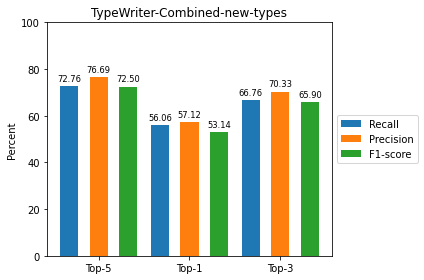

['Top-5', 'Top-1', 'Top-3'] [72.75667302929301, 56.06270526745401, 66.75870849639108] [76.69350067446209, 57.12246045799666, 70.32643812303449] [72.50292242463884, 53.138048356534505, 65.897174635333]


In [42]:
result_proc.plot_result(result_proc.eval_result(RESULTS_DIR, 'EnhancedTWModel-new', 'May15_15-07-28', 'combined',
                              'filtered', True), "TypeWriter-Combined-new-types")

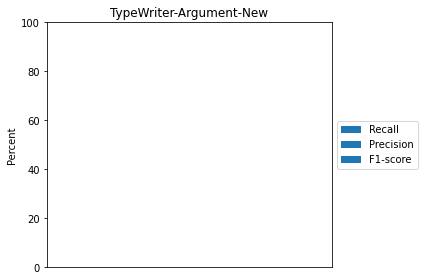

[] [] [] []


In [22]:
result_proc.plot_result(result_proc.eval_result(RESULTS_DIR, 'EnhancedTWModel', 'May13_14-55-23', 'argument',
                              'filtered', True), "TypeWriter-Argument-New")

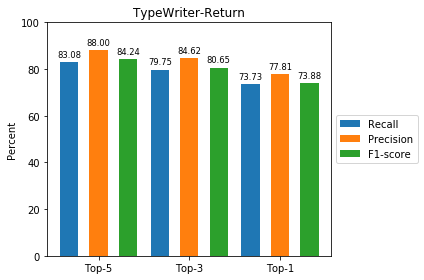

['Top-5', 'Top-3', 'Top-1'] [83.07651591831498, 79.7475677000394, 73.73461026652069] [87.9976097623528, 84.6184749135855, 77.80797060243285] [84.2408048784758, 80.64904080036537, 73.88029873801545]


In [31]:
result_proc.plot_result(result_proc.eval_result(RESULTS_DIR, 'EnhancedTWModel', 'May09_14-12-08', 'return',
                              'filtered', True), "TypeWriter-Return")

Unfiltered results

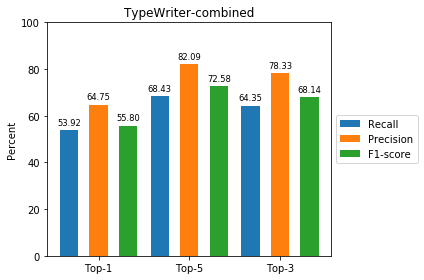

['Top-1', 'Top-5', 'Top-3'] [53.92213767377916, 68.43081345262915, 64.3510694386008] [64.74774872954619, 82.08665573397649, 78.32595054566593] [55.7994941250677, 72.5779463794482, 68.1350160157454]


In [35]:
result_proc.plot_result(result_proc.eval_result(RESULTS_DIR, 'EnhancedTWModel', 'May09_14-12-08', 'return',
                              'unfiltered', True), "TypeWriter-combined")

## RayTune

In [ ]:
from ray import tune
import ray
ray.init(memory=16 * 1024 * 1024 * 1024,
         object_store_memory=8 * 1024 * 1024 * 1024)

In [ ]:
train_loader, test_loader = tune.utils.pin_in_object_store(train_loader), tune.utils.pin_in_object_store(test_loader)

In [ ]:
idx_of_other = tune.utils.pin_in_object_store(idx_of_other)

In [ ]:
#@ray.remote
def train_TW(config):
    top_n_pred = [1, 3, 5]
    model = learn.TWModel(input_size, config['hidden_size'], X_types_param.shape[1],
                          config['num_layers'], output_size, True).to(device)

    #for i in range(1, n_rep+1):
    i=1

    learn.train_loop_TW(model, config['train_loader'], config['learning_rate'], config['epochs'])
    y_true, y_pred = learn.evaluate_TW(model, config['test_loader'], top_n=max(top_n_pred))
#     learn.train_loop_TW(model, train_loader, config['learning_rate'], config['epochs'])
#     y_true, y_pred = learn.evaluate_TW(model, test_loader, top_n=max(top_n_pred))

    # Ignore other type
    #idx_of_other = pickle.load(open(f'./output/ml_inputs/label_encoder.pkl', 'rb')).transform(['other'])[0]
    idx = (y_true != tune.utils.get_pinned_object(idx_of_other)) & (y_pred[:, 0] != tune.utils.get_pinned_object(idx_of_other))
    f1_score_top_n = []
    for top_n in top_n_pred:
        filename = f"{learn.TWModel.__name__}_complete_{i}_{top_n}"
        #learn.report_TW(y_true, y_pred, top_n, f"{filename}_unfiltered")
        report = learn.report_TW(y_true[idx], y_pred[idx], top_n, y_true.shape[0], f"{filename}_filtered")
        f1_score_top_n.append(report['weighted avg']['f1-score'])
    print("Mean f1_score:", mean(f1_score_top_n))
    ray.tune.track.log(mean_f1_score=mean(f1_score_top_n))

In [ ]:
analysis = tune.run(train_TW,
           config={'hidden_size': tune.grid_search([32, 64, 128]),
                   'num_layers': tune.grid_search([1]),
                   'learning_rate': tune.grid_search([0.002]),
                   'epochs': tune.grid_search([5]),
                   'train_loader': train_loader,
                   'test_loader': test_loader},
                   name="TypeWriter_model",
                   resources_per_trial={"cpu": 2,
                                        "gpu": 2},
                   verbose=1)
print("Best config: ", analysis.get_best_config(metric="mean_f1_score"))

In [ ]:
ray.shutdown()